In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
#importamos LogisticRegression
from sklearn.linear_model import LogisticRegression

In [3]:

# Cargar el dataset
file_path = '../../dataset/s_retail.csv'
data = pd.read_csv(file_path, delimiter=';')

# Convertir columnas de fechas a objetos datetime
date_columns = ['FECHA_FACTURA', 'MAX_FECHA_COBRO', 'FECHA_CONTABILIZACION']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extraer características de las fechas
for col in date_columns:
    data[col + '_YEAR'] = data[col].dt.year
    data[col + '_MONTH'] = data[col].dt.month
    data[col + '_DAY'] = data[col].dt.day
    data[col + '_WEEKDAY'] = data[col].dt.weekday

# Eliminar las columnas originales de fecha si ya no son necesarias
data.drop(columns=date_columns, inplace=True)

columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)

data.fillna(0, inplace=True)

# Convertir todas las entradas en las columnas categóricas a cadenas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = data[column].astype(str)

# Convertir columnas categóricas a variables numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Re-codificar las clases de la variable objetivo
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(data['CATEGORIA_FACTURA'])

# Separación de características y variable objetivo
X = data.drop('CATEGORIA_FACTURA', axis=1)

# Sobremuestreo de la clase minoritaria utilizando SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Función para evaluar el rendimiento de los modelos
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return [name, accuracy, precision, recall, f1]

# Lista para almacenar resultados
results = []

# Parámetros para GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 20, 40],
    'criterion': ['gini', 'entropy']
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_15122/923850390.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_15122/923850390.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_15122/923850390.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [4]:
#mostramos cuantos registros hay de cada clase sin usar smote 
print("Clases sin smote")
print(data['CATEGORIA_FACTURA'].value_counts())

Clases sin smote
CATEGORIA_FACTURA
-1    89767
 2    20193
 1    10498
 0      997
-2       49
Name: count, dtype: int64


In [4]:

# Árboles de Decisión
dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=cv, refit=True, verbose=2)
dt.fit(X_train, y_train)
results.append(evaluate_model("Árboles de Decisión", dt, X_test, y_test))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   2.3s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   2.7s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   2.6s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   2.6s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   2.5s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   2.4s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   2.4s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   2.7s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   2.5s
[CV] END criterion=gini, max_depth=None, min_samples_split=5; total time=   2.3s
[CV] END criterion=gini, max_depth=None, min_samples_split=10; total time=   2.3s
[CV] END criterion=gini, max_depth=None, min_sa

In [5]:
# Random Forest
rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=cv, refit=True, verbose=2)
rf.fit(X_train, y_train)
y_pred_rf = label_encoder_y.inverse_transform(rf.predict(X_test))
results.append(evaluate_model("Random Forest", rf, X_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=  42.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=  41.9s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=  41.6s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=  41.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=  42.9s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 1.4min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 1.4min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 1.4min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_est

In [6]:
# XGBoost
xgboost = GridSearchCV(xgb.XGBClassifier(), param_grid_xgb, cv=cv, refit=True, verbose=2)
xgboost.fit(X_train, y_train)
y_pred_xgb = label_encoder_y.inverse_transform(xgboost.predict(X_test))

results.append(evaluate_model("XGBoost", xgboost, X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.8s
[CV] END

In [7]:
# K-Nearest Neighbors (K-NN)
knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=cv, refit=True, verbose=2)
knn.fit(X_train, y_train)
y_pred_knn = label_encoder_y.inverse_transform(knn.predict(X_test))
results.append(evaluate_model("K-Nearest Neighbors", knn, X_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   9.5s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   9.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   9.5s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   9.4s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   9.4s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   8.6s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   8.6s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   8.5s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   8.6s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   8.6s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   9.4s
[CV] END ...metric=euclidean, n_neighbors=5, we

In [ ]:
# SVM con búsqueda de hiperparámetros
svm = GridSearchCV(SVC(), param_grid_svm, cv=cv, refit=True, verbose=2)
svm.fit(X_train, y_train)
y_pred_svm = label_encoder_y.inverse_transform(svm.predict(X_test))
results.append(evaluate_model("Support Vector Machine", svm, X_test, y_test))

In [8]:
svm = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSupport Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))



Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18004
           1       1.00      0.99      1.00     17878
           2       0.93      0.98      0.96     18080
           3       0.91      0.89      0.90     17910
           4       0.92      0.90      0.91     17895

    accuracy                           0.95     89767
   macro avg       0.95      0.95      0.95     89767
weighted avg       0.95      0.95      0.95     89767

[[18004     0     0     0     0]
 [    0 17784    70     3    21]
 [    9    17 17662   255   137]
 [    8     2   783 15865  1252]
 [   41     5   392  1354 16103]]


In [9]:
results.append(evaluate_model("Support Vector Machine", svm, X_test, y_test))


Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18004
           1       1.00      0.99      1.00     17878
           2       0.93      0.98      0.96     18080
           3       0.91      0.89      0.90     17910
           4       0.92      0.90      0.91     17895

    accuracy                           0.95     89767
   macro avg       0.95      0.95      0.95     89767
weighted avg       0.95      0.95      0.95     89767

[[18004     0     0     0     0]
 [    0 17784    70     3    21]
 [    9    17 17662   255   137]
 [    8     2   783 15865  1252]
 [   41     5   392  1354 16103]]


In [10]:
# Stacking
estimators = [
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC()),
    ('knn', KNeighborsClassifier()),
    ('xgb', xgb.XGBClassifier())
]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)
results.append(evaluate_model("Stacking", stacking, X_test, y_test))


Stacking:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18004
           1       1.00      1.00      1.00     17878
           2       0.99      0.99      0.99     18080
           3       0.95      0.95      0.95     17910
           4       0.95      0.96      0.96     17895

    accuracy                           0.98     89767
   macro avg       0.98      0.98      0.98     89767
weighted avg       0.98      0.98      0.98     89767

[[18004     0     0     0     0]
 [    0 17831    27     1    19]
 [    0    20 17971    60    29]
 [    1     0    77 17047   785]
 [    2     0    31   745 17117]]


In [ ]:
stacking: 90min
svm: +90 min
knn: 11min
xgb: 17min
rf: 51min
dt: 2min


Tabla de comparación de modelos:
                   Modelo  Exactitud  Precisión    Recall  F1-Score
0     Árboles de Decisión   0.955864   0.955658  0.955864  0.955728
1           Random Forest   0.977107   0.977068  0.977107  0.977081
2                 XGBoost   0.980984   0.980971  0.980984  0.980958
3     K-Nearest Neighbors   0.962269   0.962203  0.962269  0.962009
4  Support Vector Machine   0.951552   0.951373  0.951552  0.951317
5                Stacking   0.979982   0.979983  0.979982  0.979981


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1200x800 with 0 Axes>

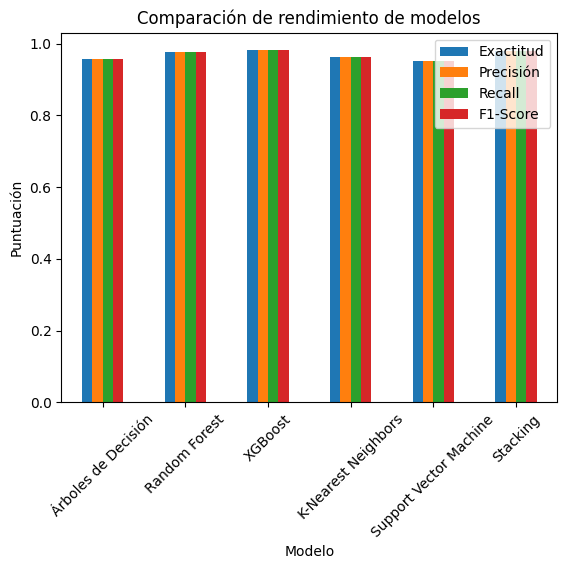

In [11]:

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results, columns=["Modelo", "Exactitud", "Precisión", "Recall", "F1-Score"])

# Mostrar la tabla de resultados
print("\nTabla de comparación de modelos:")
print(results_df)

# Graficar los resultados
plt.figure(figsize=(12, 8))
results_df.set_index("Modelo").plot(kind='bar')
plt.title('Comparación de rendimiento de modelos')
plt.ylabel('Puntuación')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show

xgboost: 165 

svm: 65

dt: 4

rf: 130

knn: 40

stacking: 230

In [27]:
# XGBoost
xgboost = GridSearchCV(xgb.XGBClassifier(), param_grid_xgb, cv=cv, refit=True, verbose=2)
xgboost.fit(X_train, y_train)
y_pred_xgb = label_encoder_y.inverse_transform(xgboost.predict(X_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.0s
[CV] END